In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import wave8_data as wave8

sys.path.append('../')
import svd_waveform_processing as proc

In [2]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

In [3]:
def removeBackground(signal, ave_window=[0,500]):
    """
    Set the baseline of the waveform to 0
    """
    if signal.ndim ==1:
        return signal - np.median(signal[ave_window[0]:ave_window[1]])
    elif signal.ndim==2:
        med = np.median(signal[:,ave_window[0]:ave_window[1]], axis=1)  
        return signal - med.reshape(med.shape[0],1)

In [4]:
dataDir = Path('./data/wave8_20200824/')
fname = '70pct_ch12.dat'
file = dataDir/fname

events = wave8.file2frames(file)
wave8data = wave8.descramble_frame(events[0])
# wave8data

ints = wave8.get_intensities(file)
diode = wave8.get_waveforms(file, 1)
apd = wave8.get_waveforms(file, 0)

diode = removeBackground(diode, ave_window=[0,30])
apd = removeBackground(apd, ave_window=[0,30])

Events read: 408
Events read: 408
Events read: 408
Events read: 408


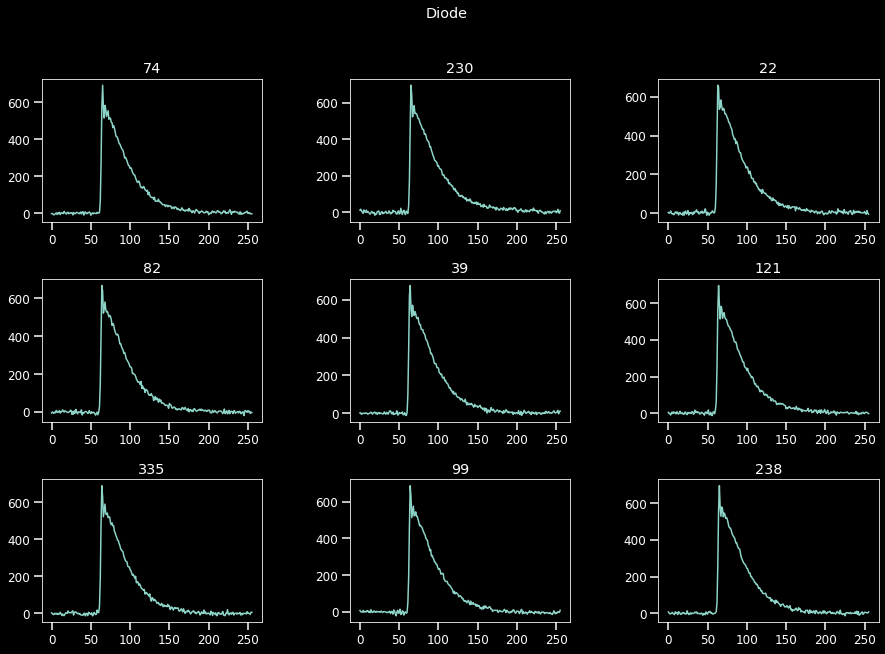

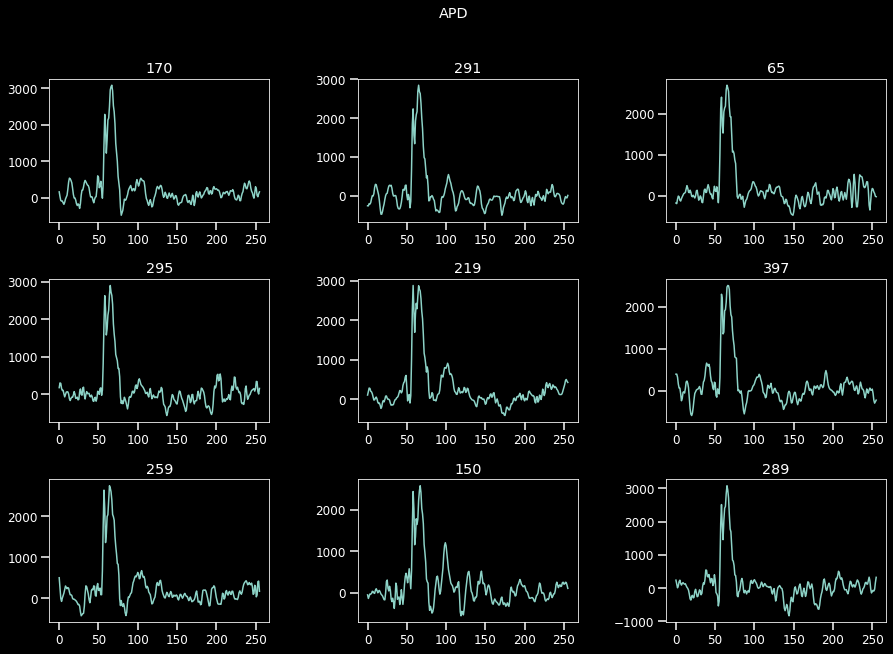

In [5]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Diode')
for ii in range(9):
    idx = np.random.randint(diode.shape[0])
    ax = fig.add_subplot(3,3,ii+1)
    ax.set_title(str(idx))
    ax.plot(diode[idx])

# plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.show()
print('\n\n')

fig = plt.figure(figsize=(15,10))
fig.suptitle('APD')
for ii in range(9):
    idx = np.random.randint(apd.shape[0])
    ax = fig.add_subplot(3,3,ii+1)
    ax.set_title(str(idx))
    ax.plot(apd[idx])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.show()

# Intensity from the firmware

## (i) Diode

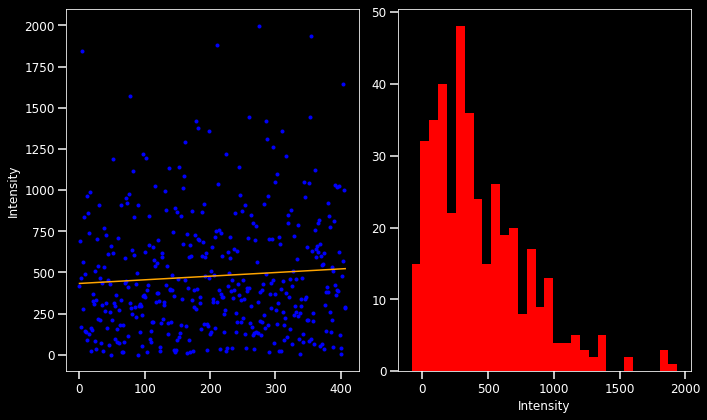

Diode standard deviation/mean: 0.84635980319044


In [22]:
intensity = ints[:,1]

fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1,2,1)
ax.set_ylabel('Intensity')
ax.plot(intensity, '.', color='blue')
fit = np.polyfit(np.arange(intensity.shape[0]), intensity, 1)
fit = np.poly1d(fit)
yfit = fit(np.arange(intensity.shape[0]))
# int_corr = intensity[:,0]-(yfit-np.mean(yfit))
int_corr = intensity-(yfit-yfit[0])
ax.plot(yfit, 'orange')
ax = plt.subplot(1,2,2)
ax.set_xlabel('Intensity')
ax.hist(int_corr, bins=30, color='r')
plt.tight_layout()
plt.show()
# fig.savefig('APD_SN_corr.png')

average = np.mean(int_corr)
sigma = np.std(int_corr)
print('Diode standard deviation/mean:',sigma/average)

## (ii) APD

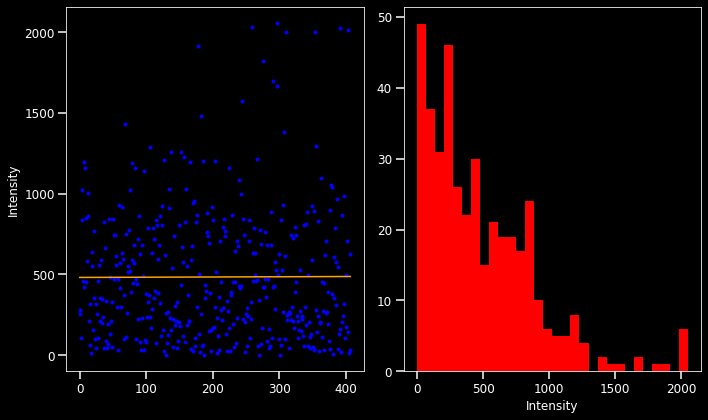

Diode standard deviation/mean: 0.8467631593374911


In [23]:
intensity = ints[:,0]

fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1,2,1)
ax.set_ylabel('Intensity')
ax.plot(intensity, '.', color='blue')
fit = np.polyfit(np.arange(intensity.shape[0]), intensity, 1)
fit = np.poly1d(fit)
yfit = fit(np.arange(intensity.shape[0]))
# int_corr = intensity[:,0]-(yfit-np.mean(yfit))
int_corr = intensity-(yfit-yfit[0])
ax.plot(yfit, 'orange')
ax = plt.subplot(1,2,2)
ax.set_xlabel('Intensity')
ax.hist(int_corr, bins=30, color='r')
plt.tight_layout()
plt.show()
# fig.savefig('APD_SN_corr.png')

average = np.mean(int_corr)
sigma = np.std(int_corr)
print('Diode standard deviation/mean:',sigma/average)

There seem to be somehting wrong with the signal processing in the firmware. Were the integration limit set properly?
Or is the intensity properly decoded by the function reading the data?

# With SVD analysis

## (i) Diode

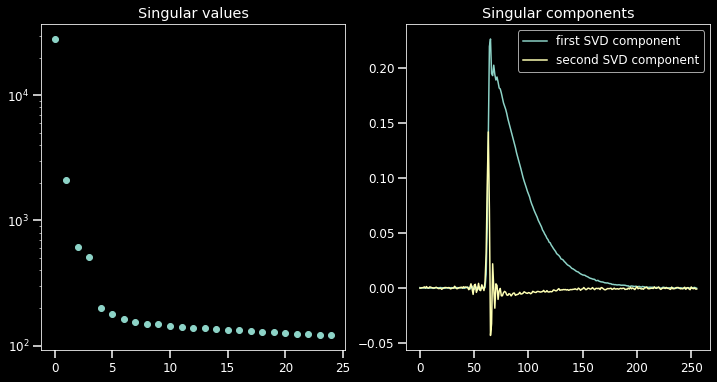

In [8]:
A, proj, svd = proc.get_basis_and_projector(diode[:100], n_components=1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(svd.singular_values_,'o')
plt.yscale('log')
plt.title('Singular values')

plt.subplot(1,2,2)
plt.plot(svd.components_[0], label='first SVD component')
plt.plot(svd.components_[1]*0.2, label='second SVD component')
# plt.plot(svd.components_[3], 'r', label='third SVD component')
plt.title('Singular components')
plt.legend()
plt.show()

In [9]:
diode_regressor = proc.construct_waveformRegressor(diode[:100])

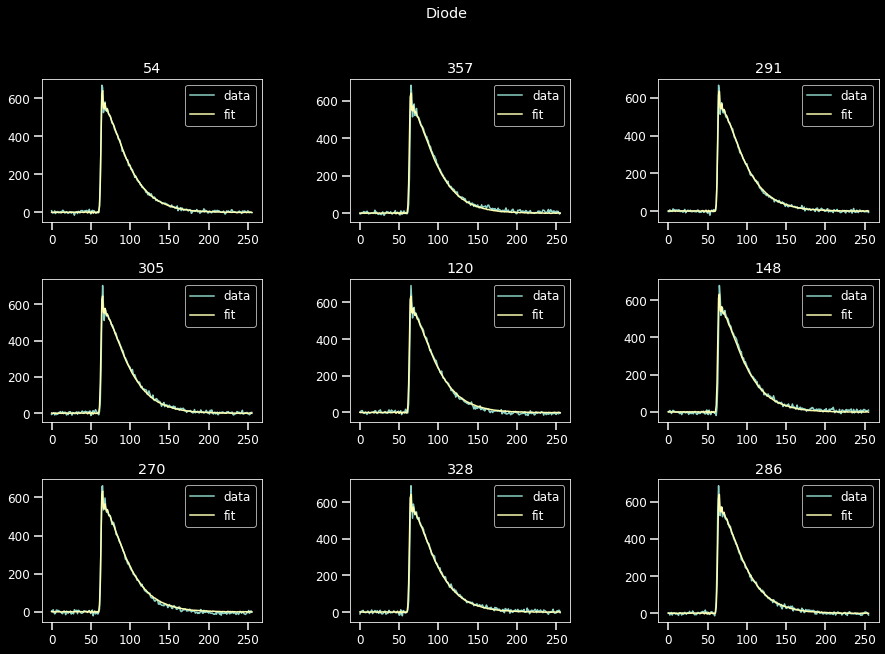

In [10]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Diode')
for ii in range(9):
    idx = np.random.randint(diode.shape[0])
    ax = fig.add_subplot(3,3,ii+1)
    ax.set_title(str(idx))
    ax.plot(diode[idx], label='data')
    ax.plot(diode_regressor.fit_reconstruct(diode[idx]).T, label='fit')
    ax.legend()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.show()

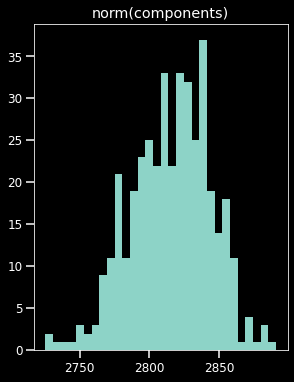

Thorlabs diode standard deviation/mean: 0.01007409326991057


In [11]:
intensity = np.squeeze(diode_regressor.get_pulse_intensity(diode))
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title('norm(components)')
plt.hist(intensity, bins=30)
# plt.subplot(1,2,2)
# plt.title('max(fit)')
# plt.hist(intensity[:,1], bins=30)
plt.show()

average = np.mean(intensity)
sigma = np.std(intensity)
print('Thorlabs diode standard deviation/mean:',sigma/average)

## (ii) APD

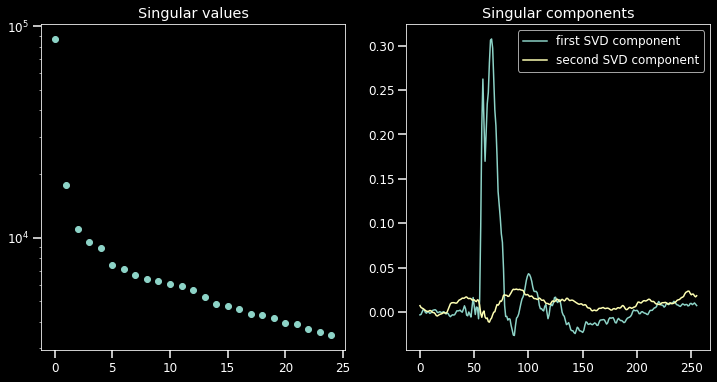

In [12]:
A, proj, svd = proc.get_basis_and_projector(apd[:100], n_components=1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(svd.singular_values_,'o')
plt.yscale('log')
plt.title('Singular values')

plt.subplot(1,2,2)
plt.plot(svd.components_[0], label='first SVD component')
plt.plot(svd.components_[1]*0.2, label='second SVD component')
# plt.plot(svd.components_[3], 'r', label='third SVD component')
plt.title('Singular components')
plt.legend()
plt.show()

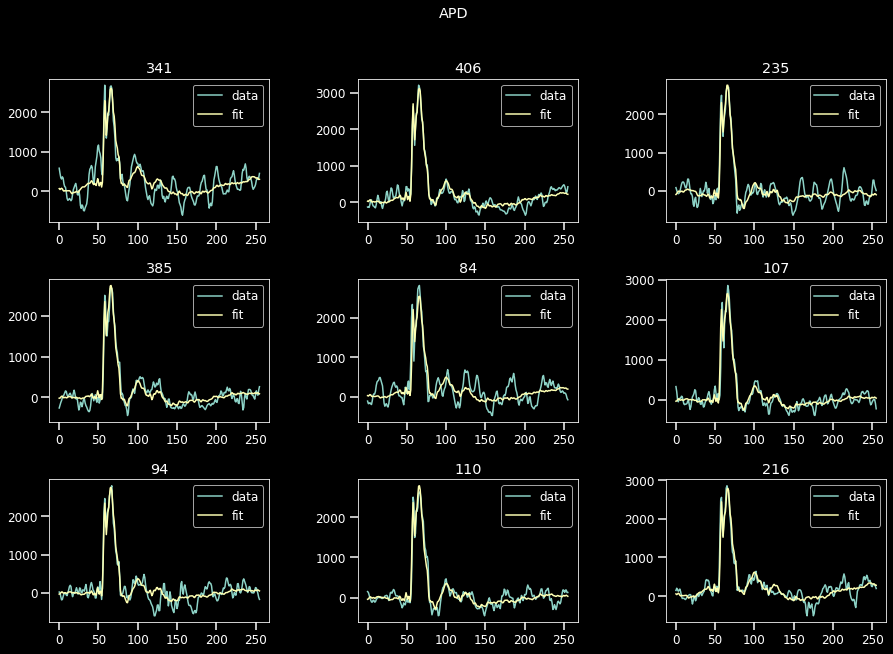

In [13]:
APD_regressor = proc.construct_waveformRegressor(apd[:100], n_components=2)

fig = plt.figure(figsize=(15,10))
fig.suptitle('APD')
for ii in range(9):
    idx = np.random.randint(apd.shape[0])
    ax = fig.add_subplot(3,3,ii+1)
    ax.set_title(str(idx))
    ax.plot(apd[idx], label='data')
    ax.plot(APD_regressor.fit_reconstruct(apd[idx]).T, label='fit')
    ax.legend()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.show()

fig.savefig('./APD_fits.png')

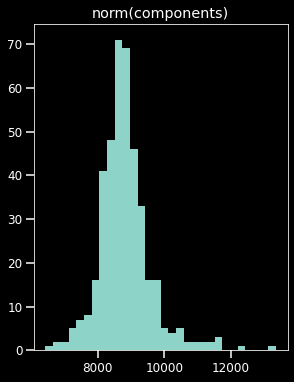

APD standard deviation/mean: 0.09034815400074261


In [14]:
intensity = APD_regressor.get_pulse_intensity(apd)
plt.figure(figsize=(10,6))
ax = plt.subplot(1,2,1)
plt.title('norm(components)')
ax.hist(intensity[:,0], bins=30)
# ax = plt.subplot(1,2,2)
# plt.title('max(fit)')
# ax.hist(intensity[:,1], bins=30)
plt.show()

average = np.mean(intensity)
sigma = np.std(intensity)
print('APD standard deviation/mean:',sigma/average)

# Analyze all the runs

In [15]:
def analyze_wave8_wfs(file, channel, n_components):
    wfs = wave8.get_waveforms(file, channel)
    wfs = removeBackground(wfs, ave_window=[0,30])
    regressor = proc.construct_waveformRegressor(wfs[:100], n_components=n_components)
    
    fig = plt.figure(figsize=(15,10))
    fig.suptitle(file.name)
    for ii in range(9):
        idx = np.random.randint(wfs.shape[0])
        ax = fig.add_subplot(3,3,ii+1)
        ax.set_title(str(idx))
        ax.plot(wfs[idx], label='data')
        ax.plot(regressor.fit_reconstruct(wfs[idx]).T, label='fit')
        ax.legend()

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
    
    intensity = regressor.get_pulse_intensity(wfs)
    average = np.mean(intensity)
    sigma = np.std(intensity)
    rms = sigma/average
    fig, ax = plt.subplots(ncols=2, figsize=(10,6))
    ax[0].plot(intensity, '.', color='orange')
    ax[0].set_ylabel('Intensity')
    ax[1].set_title('Intensity: norm(components)')
    ax[1].hist(intensity[:,0], bins=30, label='rms={:.05f}'.format(rms))
    ax[1].legend()
    plt.show()

    print('Standard deviation/mean:',rms)
    print('\n\n')
    
    return sigma/average, intensity, wfs, regressor

In [16]:
dat_ids = [60,70,80,85,90,95,100]
rmss = np.zeros((len(dat_ids),2))

## (i) Diode

Events read: 405


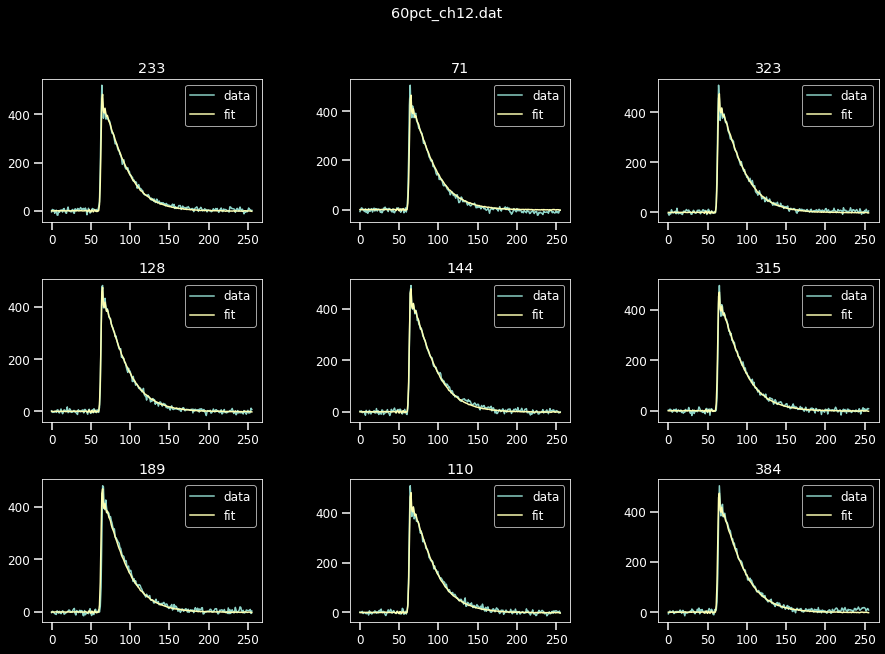

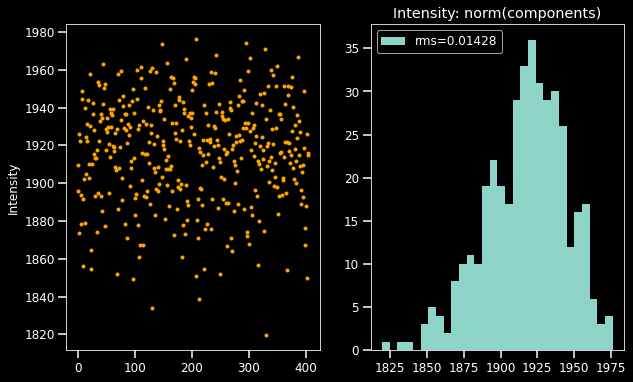

Standard deviation/mean: 0.014279241755496667



Events read: 408


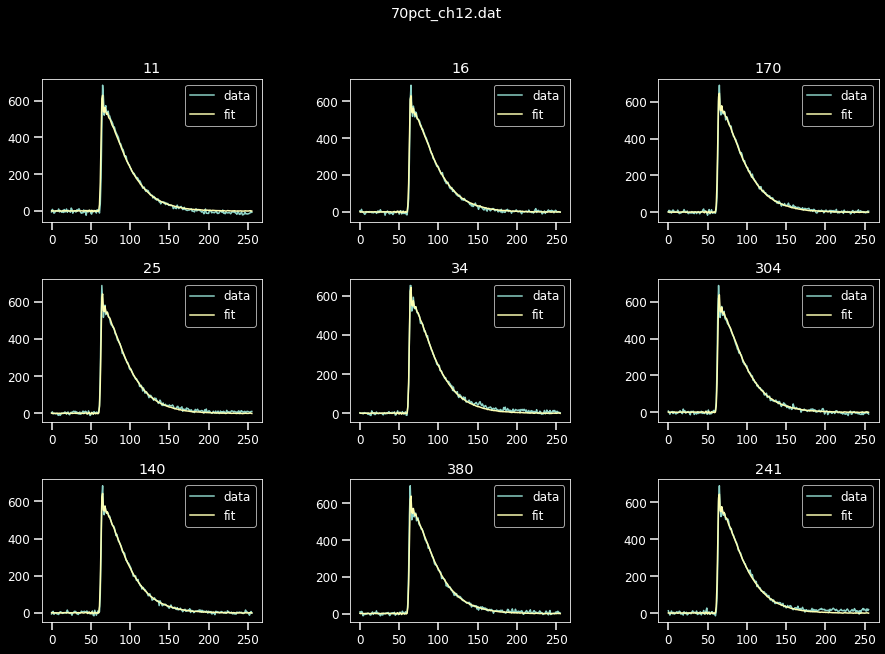

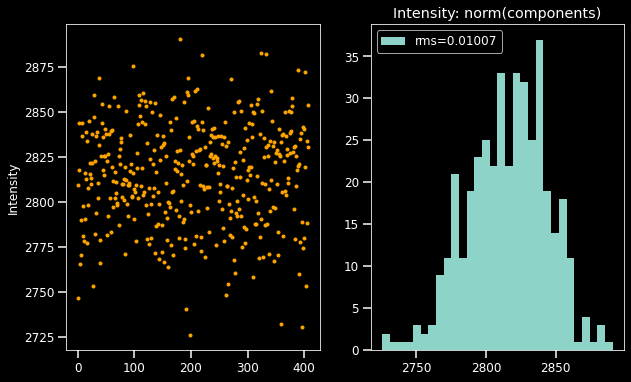

Standard deviation/mean: 0.010074093269910588



Events read: 410


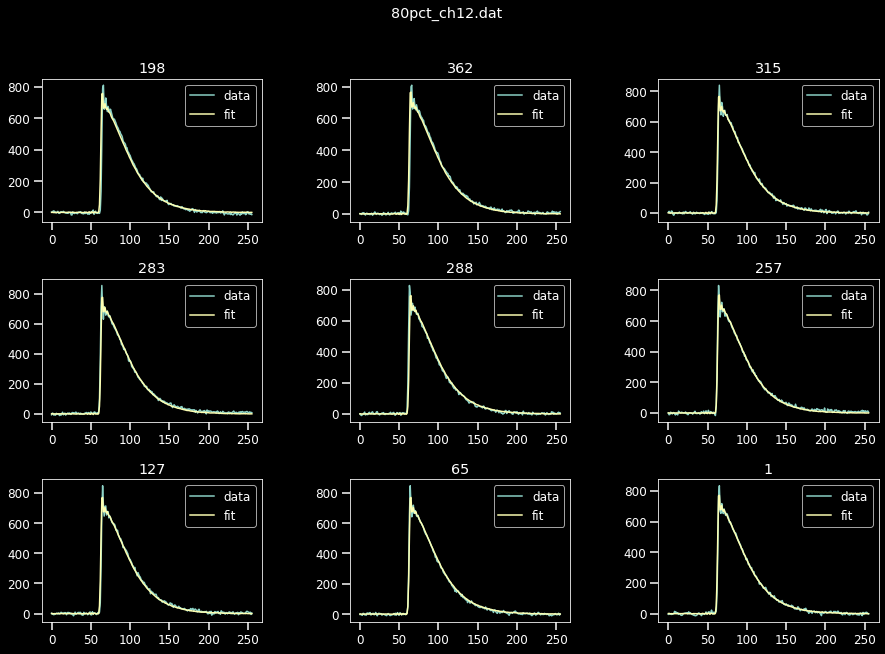

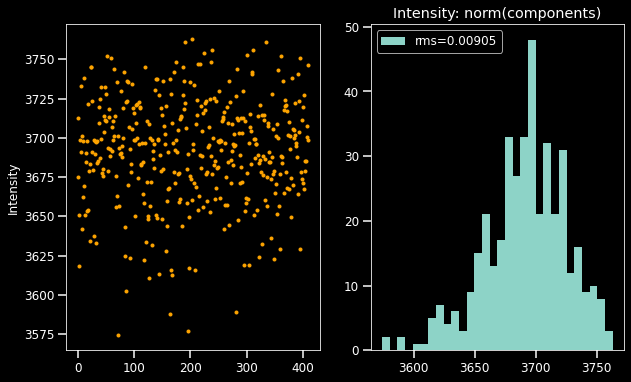

Standard deviation/mean: 0.009045257561442862



Events read: 413


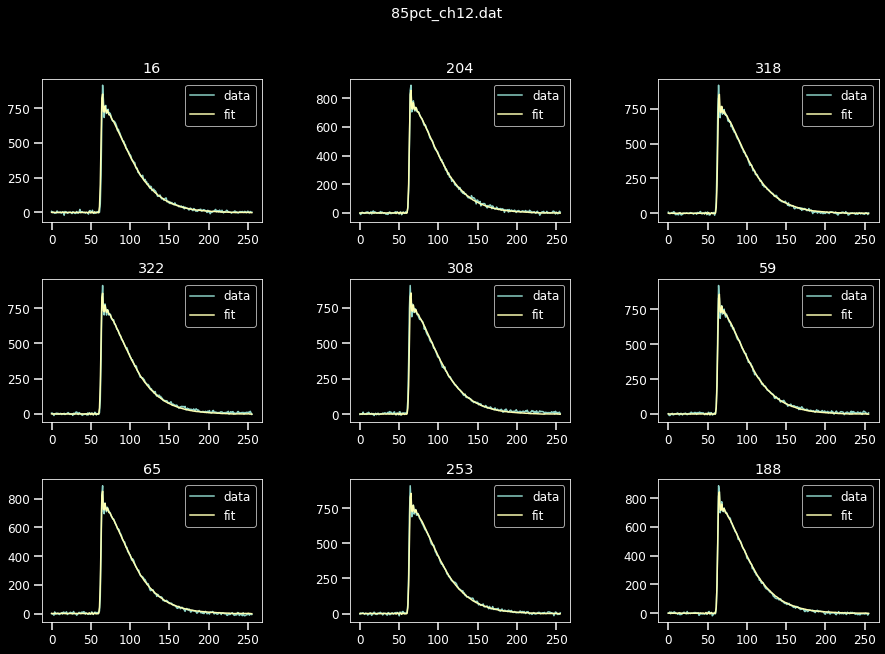

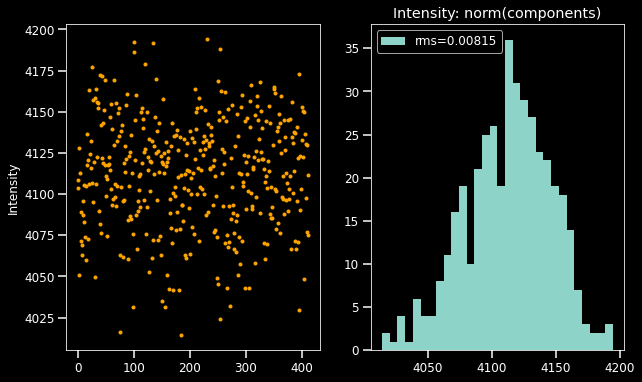

Standard deviation/mean: 0.008146661211129818



Events read: 407


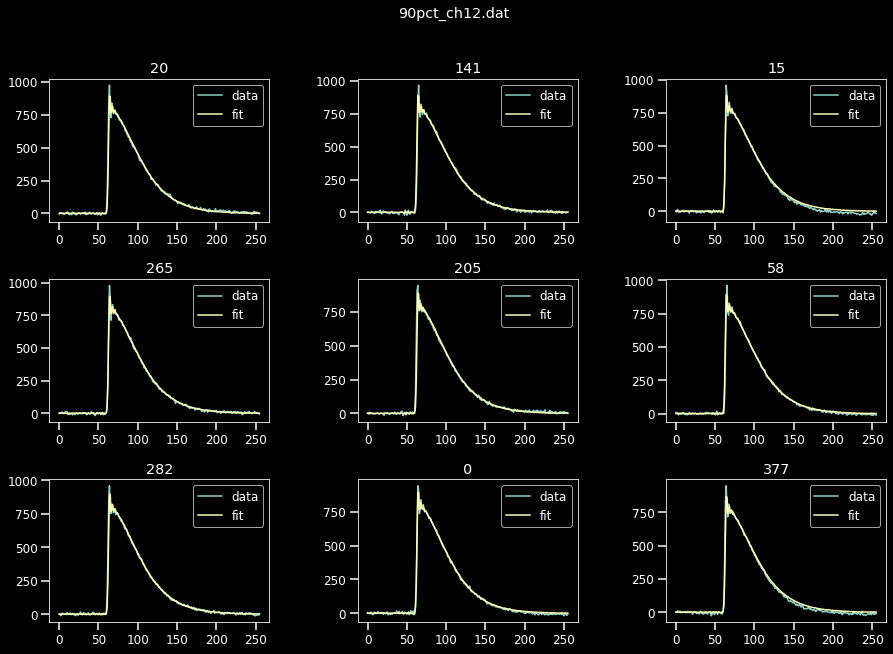

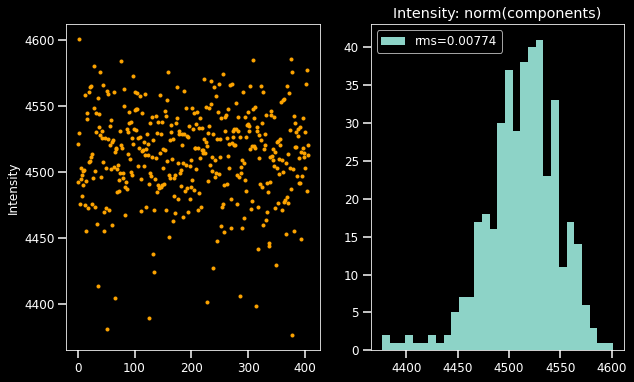

Standard deviation/mean: 0.00774348028906398



Events read: 464


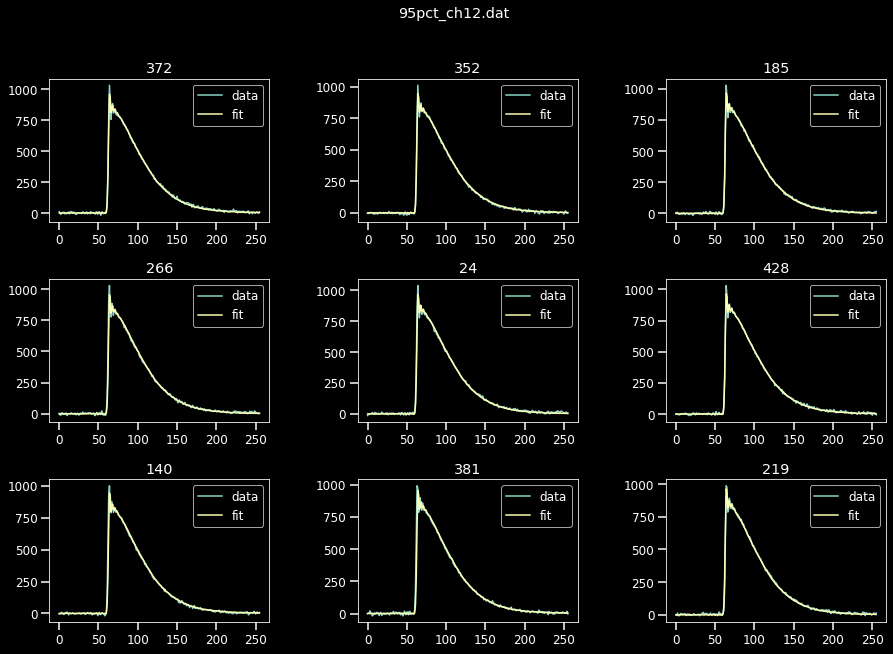

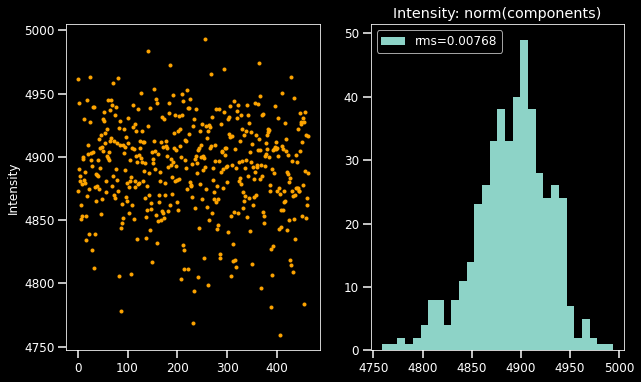

Standard deviation/mean: 0.007682605644251612



Events read: 411


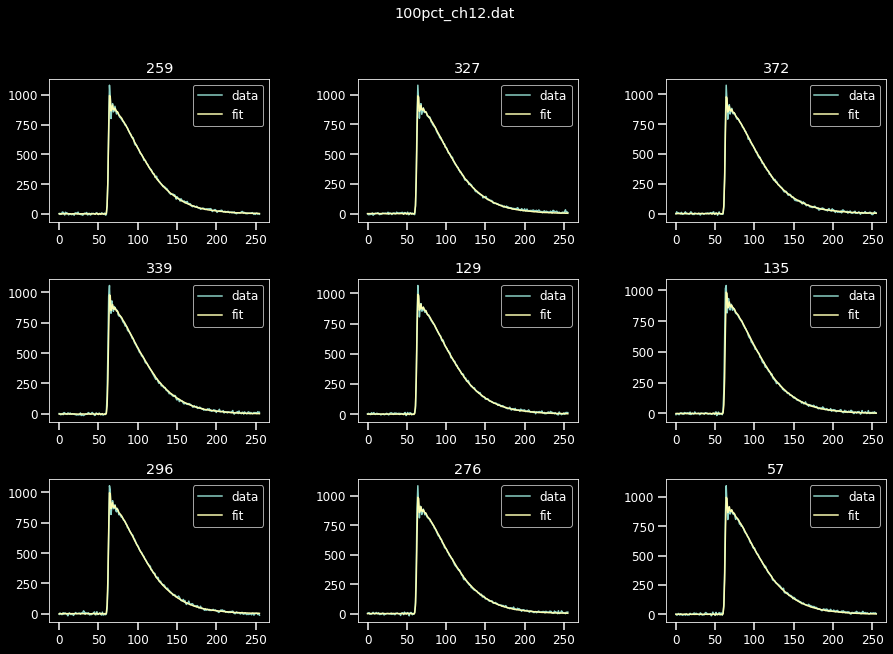

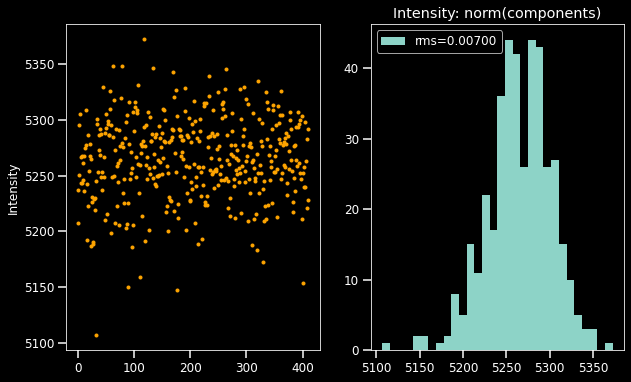

Standard deviation/mean: 0.007003657047114518





In [17]:
for ii, dat_idx in enumerate(dat_ids):
    fname = '{}pct_ch12.dat'.format(dat_idx)
    file = dataDir/fname
    rms, _, _, _ = analyze_wave8_wfs(file, 1, 1)
    rmss[ii,0] = rms

## (ii) APD

Events read: 405


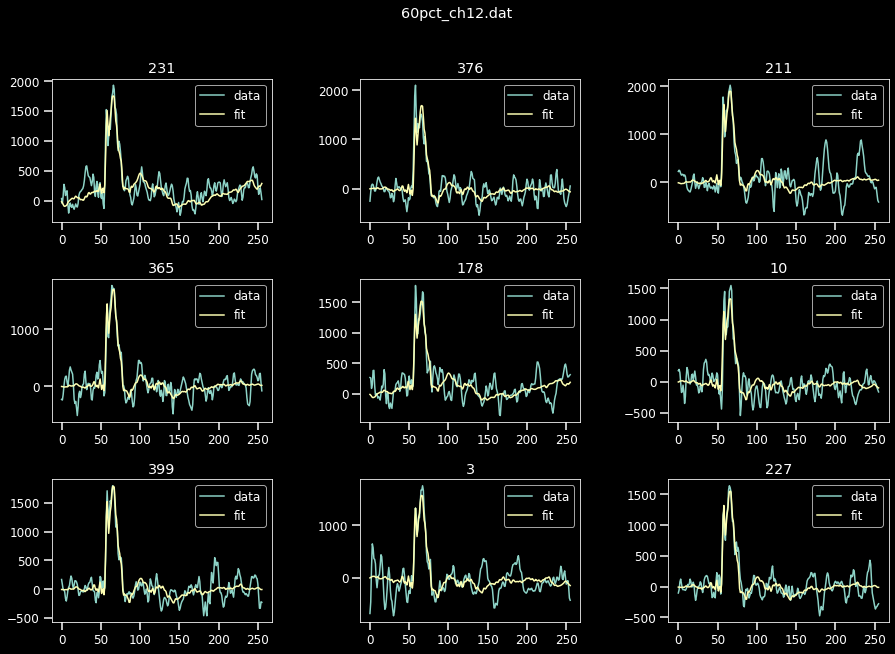

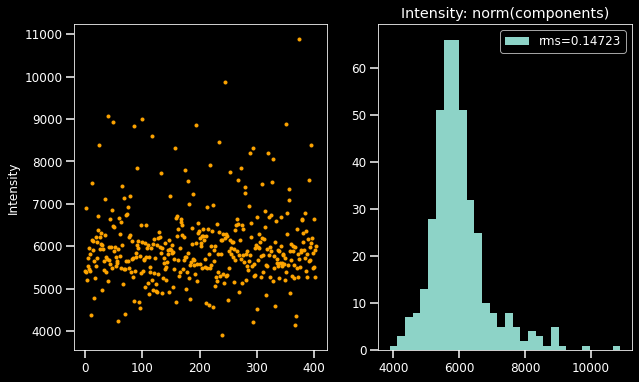

Standard deviation/mean: 0.1472280767147443



Events read: 408


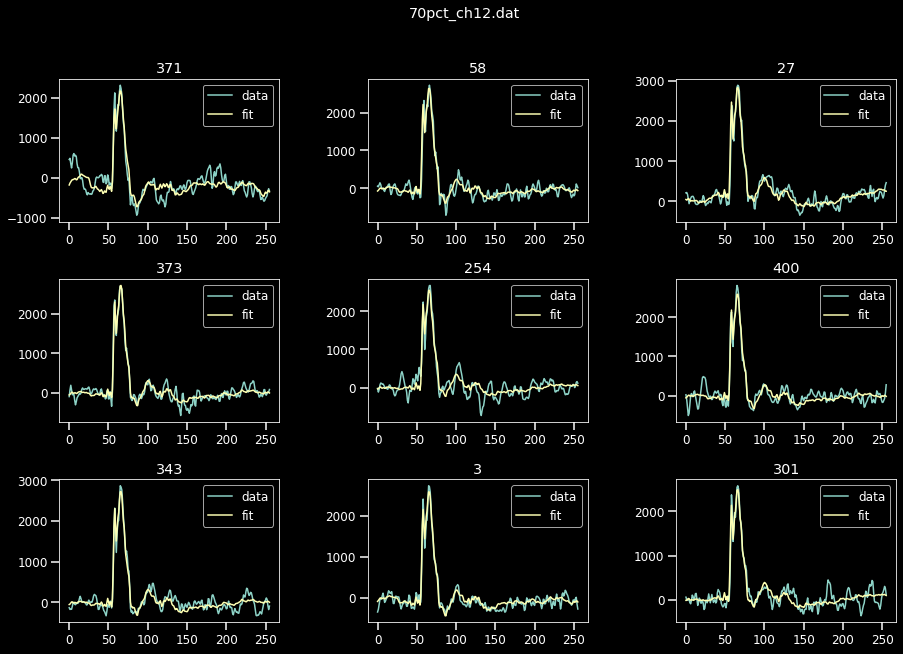

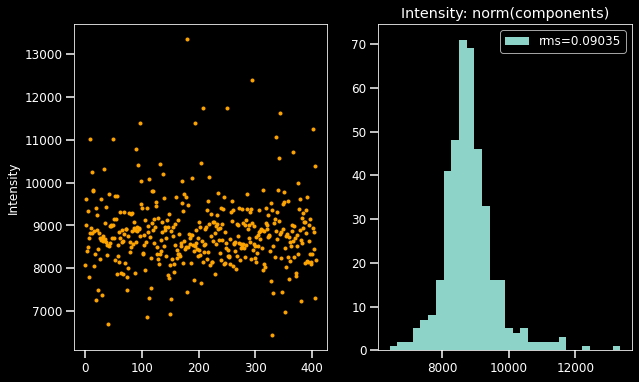

Standard deviation/mean: 0.09034815400074261



Events read: 410


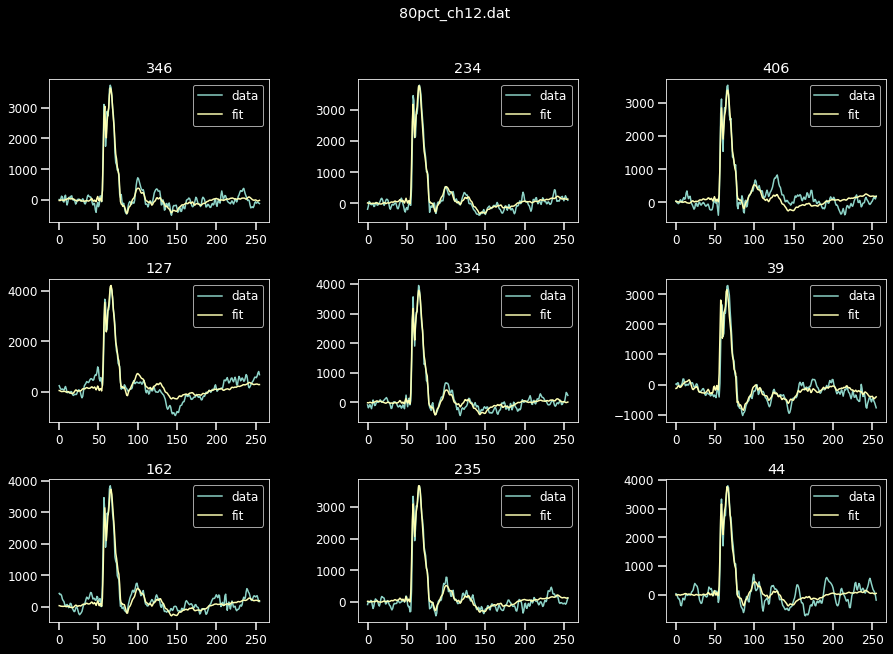

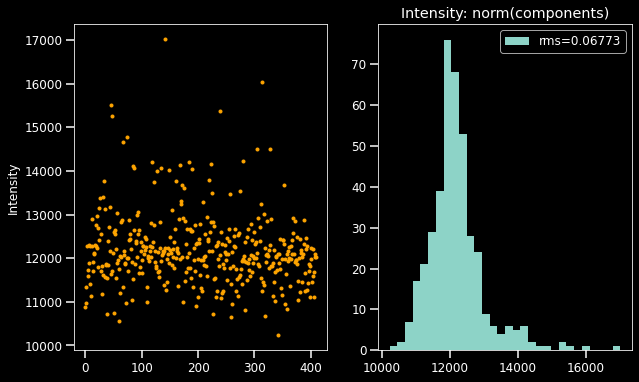

Standard deviation/mean: 0.06772803637197831



Events read: 413


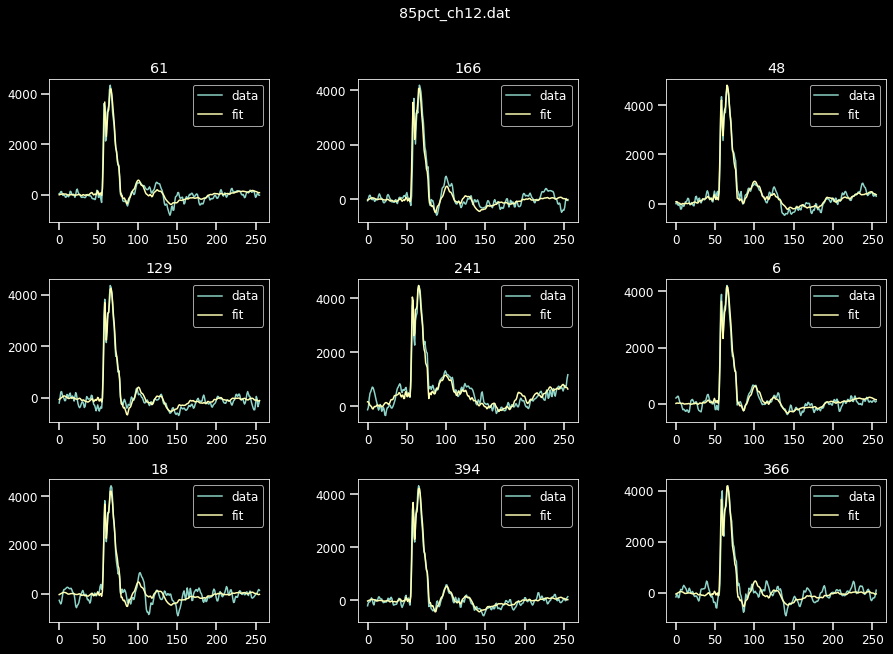

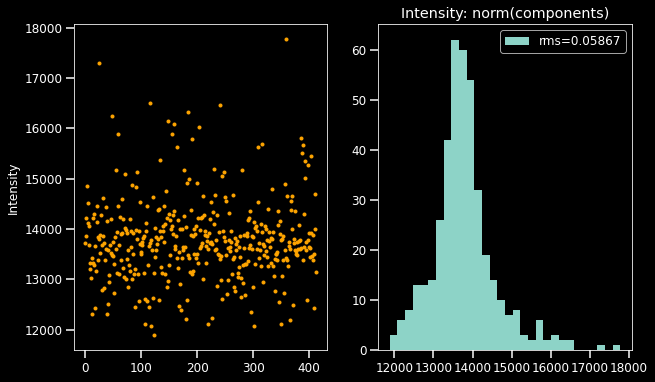

Standard deviation/mean: 0.05867170343687396



Events read: 407


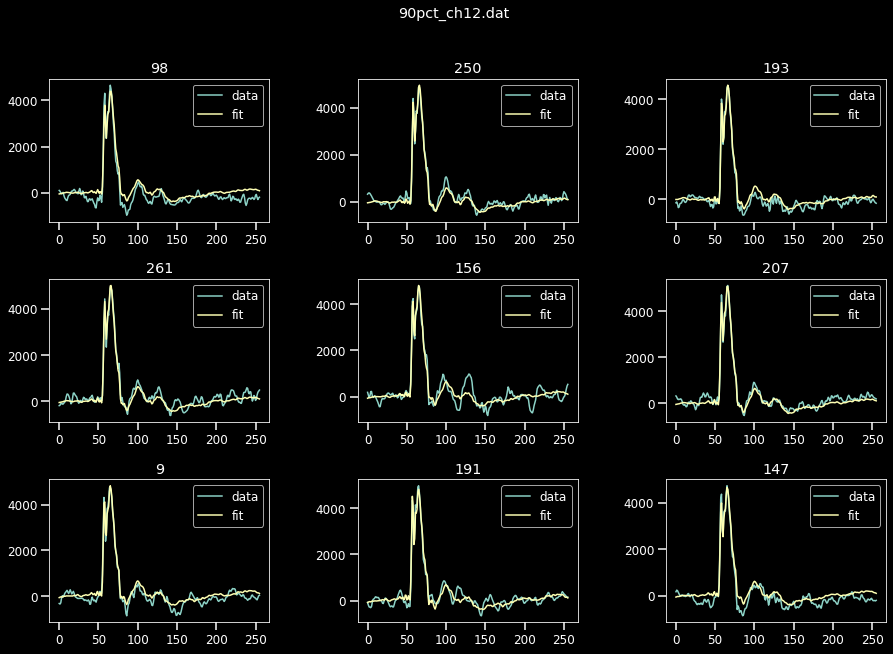

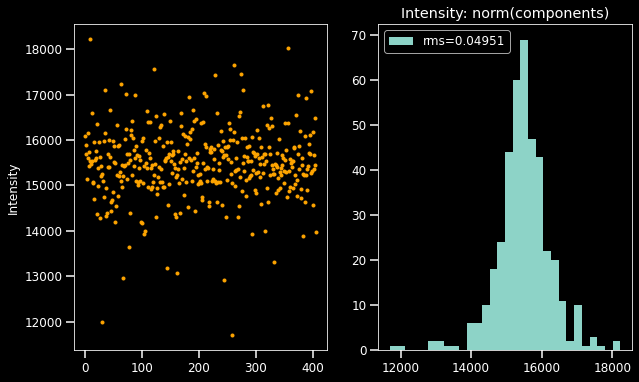

Standard deviation/mean: 0.04950882783708385



Events read: 464


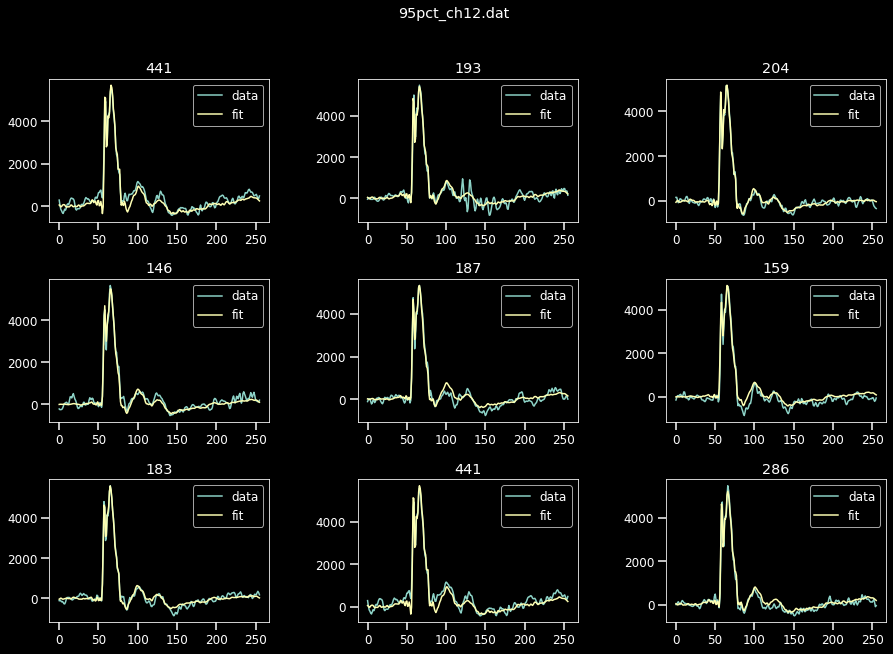

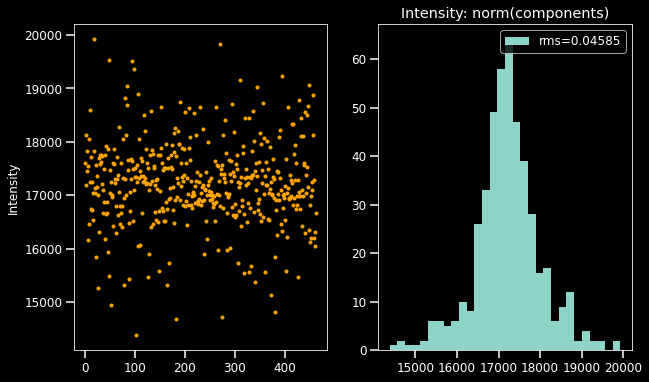

Standard deviation/mean: 0.045848634848049144



Events read: 411


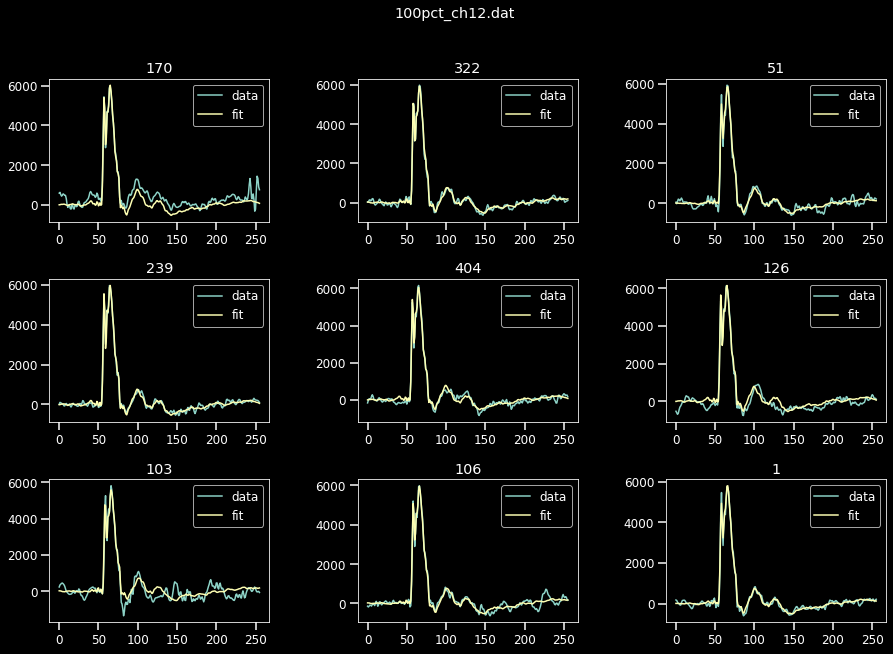

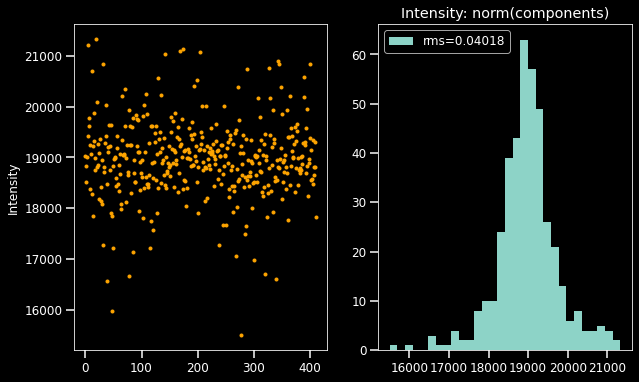

Standard deviation/mean: 0.040184054730553996





In [18]:
for ii, dat_idx in enumerate(dat_ids):
    fname = '{}pct_ch12.dat'.format(dat_idx)
    file = dataDir/fname
    rms, _, _, _ = analyze_wave8_wfs(file, 0, 2)
    rmss[ii,1] = rms

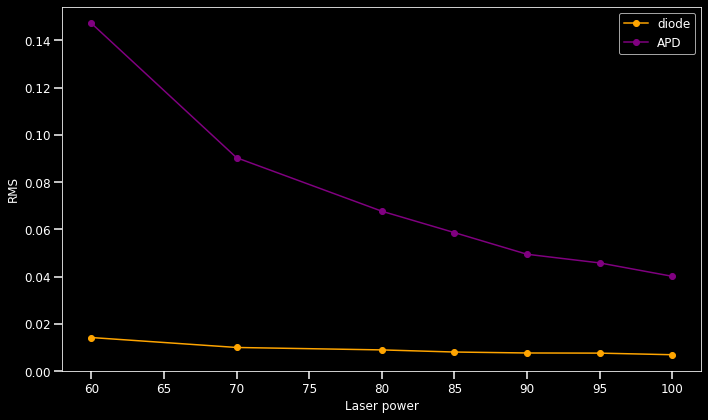

In [19]:
fig, ax = plt.subplots()
ax.plot(dat_ids, rmss[:,0], '-o', label='diode', color='orange')
ax.plot(dat_ids, rmss[:,1], '-o', label='APD', color='purple')
ax.set_xlabel('Laser power')
ax.set_ylabel('RMS')
ax.legend()
plt.tight_layout()
plt.show()

fig.savefig('./aug2020_summary.png')